# Weekly Project 4

## Stereo camera calibration
This week you'll be provided with a set of stereo images, and your task is to undistort and rectify the images, such that they can be used with the stereo depth reconstruction you made on day 6. You are still not allowed to use opencv functions for block matching/template matching, however you are free to use opencv when undistorting the images. It is recommended that you finish the exercises from Monday before continuing with the weekly project.

The image sets are found in the attached zip-file. Start with the rs.zip and move on to mynteye.zip once you have it working. The physical dimensions of each square of the pattern are 33.6 x 33.6 mm.

In [1]:
import cv2
import numpy as np
import glob
from matplotlib import pyplot as plt

Calibrating the camera

In [2]:
path = "C:/Users/shaia/Documents/Opgaveregning/AutoSys/4. semester/Perception for autonome systemer/Projekt 4/"

nb_vertical = 9
nb_horizontal = 6

squaresize = 33.6
objp = np.zeros((nb_horizontal * nb_vertical, 3), np.float32)
objp[:, :2] = np.mgrid[0:nb_vertical, 0:nb_horizontal].T.reshape(-1, 2) * squaresize

objpoints = []
imgpointsLeft = []
imgpointsRight = []

images = glob.glob(path + "rs/left*.png")
assert images

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(img, (nb_vertical, nb_horizontal), None)

    if ret == True:
        objpoints.append(objp)
        imgpointsLeft.append(corners)

        img = cv2.drawChessboardCorners(img, (nb_vertical, nb_horizontal), corners, ret)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

images = glob.glob(path + "rs/right*.png")
assert images

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(img, (nb_vertical, nb_horizontal), None)

    if ret == True:
        imgpointsRight.append(corners)

        img = cv2.drawChessboardCorners(img, (nb_vertical, nb_horizontal), corners, ret)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

imgLeft = cv2.imread(path + "rs/left-0009.png")
imgRight = cv2.imread(path + "rs/right-0009.png")

imgLeft = cv2.cvtColor(imgLeft, cv2.COLOR_BGR2RGB)
imgRight = cv2.cvtColor(imgRight, cv2.COLOR_BGR2RGB)

grayLeft = cv2.cvtColor(imgLeft, cv2.COLOR_BGR2GRAY)
grayRight = cv2.cvtColor(imgRight, cv2.COLOR_BGR2GRAY)

h, w = grayLeft.shape

retLeft, mtxLeft, distLeft, rvecsLeft, tvecsLeft = cv2.calibrateCamera(objpoints, imgpointsLeft, grayLeft.shape[::-1], None, None)
retRight, mtxRight, distRight, rvecsRight, tvecsRight = cv2.calibrateCamera(objpoints, imgpointsRight, grayRight.shape[::-1], None, None)


criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
retval, mtxLeft, distLeft, mtxRight, distRight, R, T, E, F = cv2.stereoCalibrate(
    objpoints,
    imgpointsLeft,
    imgpointsRight,
    mtxLeft, distLeft,
    mtxRight, distRight,
    (w, h),
    criteria=criteria,
    flags=cv2.CALIB_FIX_INTRINSIC
)

newcameramtxLeft, roiLeft = cv2.getOptimalNewCameraMatrix(mtxLeft, distLeft, (w, h), 1, (w, h))
newcameramtxRight, roiRight = cv2.getOptimalNewCameraMatrix(mtxRight, distRight, (w, h), 1, (w, h))

Undistortion and rectify

Text(0.5, 1.0, 'Undistorted and rectified right image')

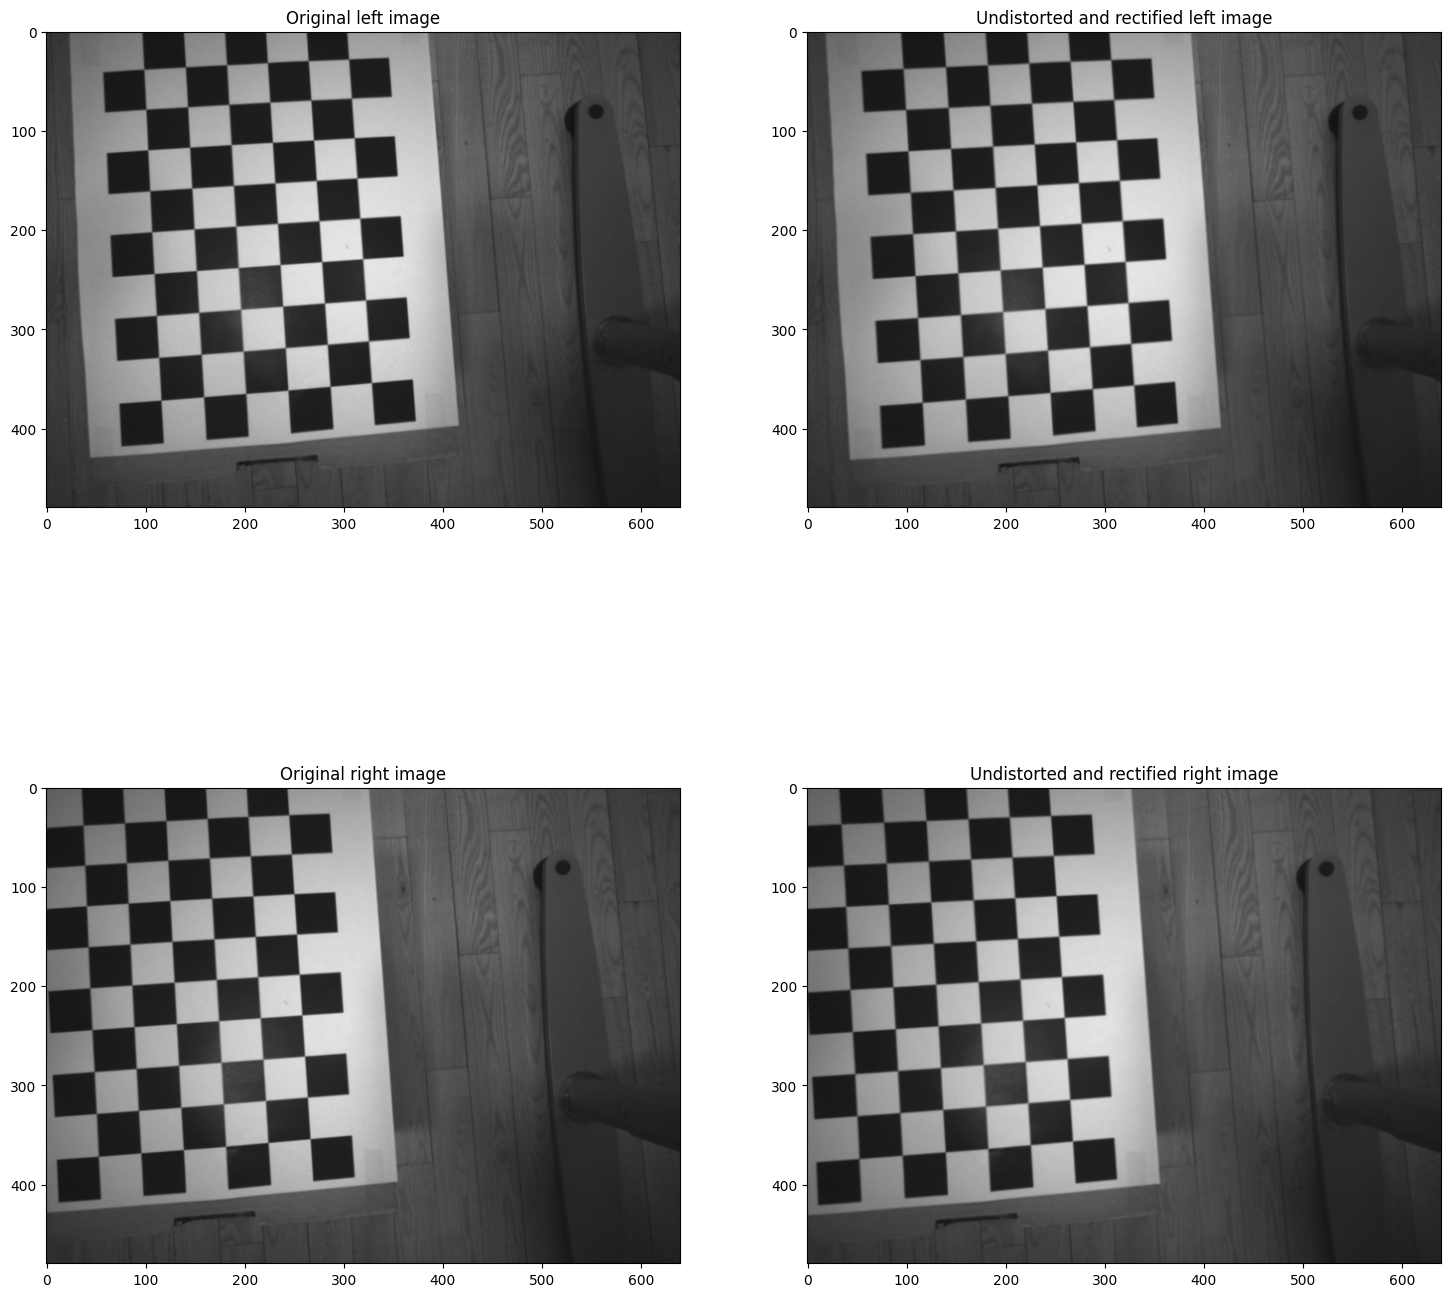

In [3]:
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(mtxLeft, distLeft, mtxRight, distRight, grayLeft.shape[::-1], R, T)

map1Left, map2Left = cv2.initUndistortRectifyMap(mtxLeft, distLeft, R1, P1, gray.shape[::-1], cv2.CV_16SC2)
map1Right, map2Right = cv2.initUndistortRectifyMap(mtxRight, distRight, R2, P2, gray.shape[::-1], cv2.CV_16SC2)

rectLeft = cv2.remap(imgLeft, map1Left, map2Left, cv2.INTER_LINEAR)
rectRight = cv2.remap(imgRight, map1Right, map2Right, cv2.INTER_LINEAR)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 18))
ax[0, 0].imshow(imgLeft[..., [2, 1, 0]])
ax[0, 0].set_title('Original left image')
ax[0, 1].imshow(rectLeft[..., [2, 1, 0]])
ax[0, 1].set_title('Undistorted and rectified left image')
ax[1, 0].imshow(imgRight[..., [2, 1, 0]])
ax[1, 0].set_title('Original right image')
ax[1, 1].imshow(rectRight[..., [2, 1, 0]])
ax[1, 1].set_title('Undistorted and rectified right image')

Matching images

(([], []), ([], []))

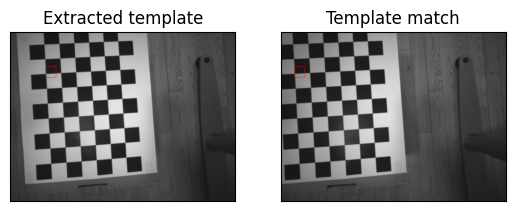

In [4]:
def SAD(left, right):
    left = left.astype(np.int32)
    right = right.astype(np.int32)
    return np.sum(np.abs(left - right))

def spanSAD(template, image):
    matSAD = np.zeros((image.shape[1] - template.shape[1] + 1, 1))
    for col in range(matSAD.shape[0]):
        matSAD[col] = SAD(template, image[:, col:col + template.shape[1]])
    
    return matSAD

grayLeft = cv2.cvtColor(rectLeft, cv2.COLOR_RGB2GRAY)
grayRight = cv2.cvtColor(rectRight, cv2.COLOR_RGB2GRAY)

template_x = (100, 130)
template_y = (100, 130)
template = grayLeft[template_x[0]:template_x[1], template_y[0]:template_y[1]]
template_area = cv2.rectangle(rectLeft.copy(), (template_y[0], template_x[0]), (template_y[1], template_x[1]), (255, 0, 0), 1)

span = spanSAD(template, grayRight[template_x[0]:template_x[1], :])
best_match = np.argmin(span)

image_match = cv2.rectangle(rectRight.copy(), (np.int64(best_match), template_x[0]), (np.int64(best_match) + template.shape[0], template_x[1]), (255, 0, 0), 1)

plt.subplot(1, 2, 1)
plt.imshow(template_area)
plt.title('Extracted template')
plt.xticks([]), plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(image_match)
plt.title('Template match')
plt.xticks([]), plt.yticks([])